In [4]:
# Libraries
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Custom functions
import sys
sys.path.append('../src')

# Global variables

nodeinfo_path = '../data/processed/node_info.csv'
ismn_path = '../data/processed/ISMN_dataset.h5'

# ISMN Time Dimension Problem

The main issue when working with the data from ISMN is that the records are not in sync with each other. Ideally we would have a datacube with (Node_name, Timestamp/datetime) dimensions, and those will only be for the year 2017

In [2]:
ismn_dataset = xr.open_dataset(ismn_path)
ismn_dataset

<xarray.Dataset>
Dimensions:       (Register: 96432, Node_name: 1369)
Coordinates:
  * Register      (Register) int32 0 1 2 3 4 5 ... 96427 96428 96429 96430 96431
  * Node_name     (Node_name) object 'ARM\\Anthony' ... 'WSMN\\WSMN-2'
Data variables:
    values        (Node_name, Register) float64 ...
    timestamp     (Node_name, Register) float64 ...
    quality_flag  (Node_name, Register) float64 ...
    2017_mask     (Node_name, Register) bool ...
    node_tag      (Node_name) object ...
    lat           (Node_name) float64 ...
    lon           (Node_name) float64 ...

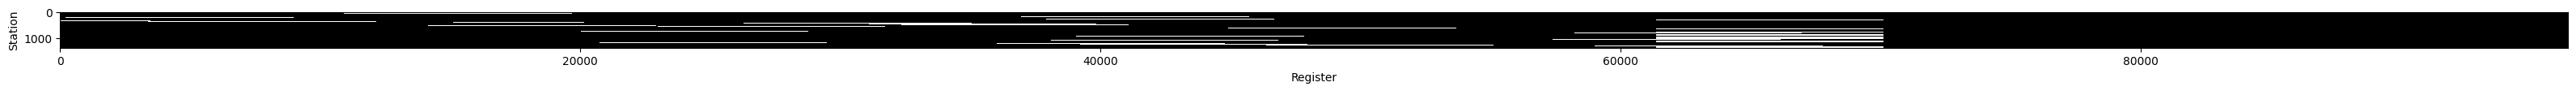

In [3]:
plt.figure(figsize=(40,2))
plt.imshow(ismn_dataset["2017_mask"], cmap='gray', interpolation='nearest')
plt.xlabel('Register')
plt.ylabel('Station')
plt.show()

In [19]:
# Lets create a new dimention, one for each hour in 2017's year and coded as a timestamp

start_2017 = int(datetime(2017,1,1,0,0,0).timestamp())
end_2017 = int(datetime(2017,12,31,23,0,0).timestamp())

valid_times = [value for value in range(start_2017 + 3600,end_2017,3600)]
print(len(valid_times), valid_times[0], valid_times[-1])

8758 1483228800 1514754000


In [132]:
times = ismn_dataset.where(ismn_dataset["2017_mask"] == True)["timestamp"][200,:]
recorded_times = times[ismn_dataset["2017_mask"][200,:]].values

[ True  True  True ...  True  True  True]


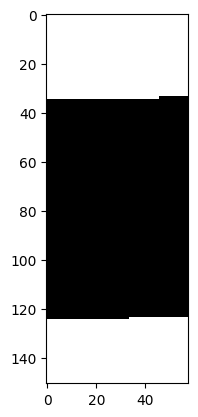

In [133]:
print((recorded_times == valid_times))
plt.imshow((recorded_times == valid_times).reshape(151,58), cmap='gray', interpolation='nearest')

In [113]:
# Daylight Saving Time is a BIG Issue, I could add one when the records dont match and when the time shwiches back I would have the same hour

actual_recorded_time = recorded_times.copy()
actual_recorded_time[actual_recorded_time != valid_times] +=  3600
# TODO: This could be ok in the northen hemisphere, but in the south the fisrt time it's changed, we need to subtract 1h, not add one hour, since they start the year ON DST.

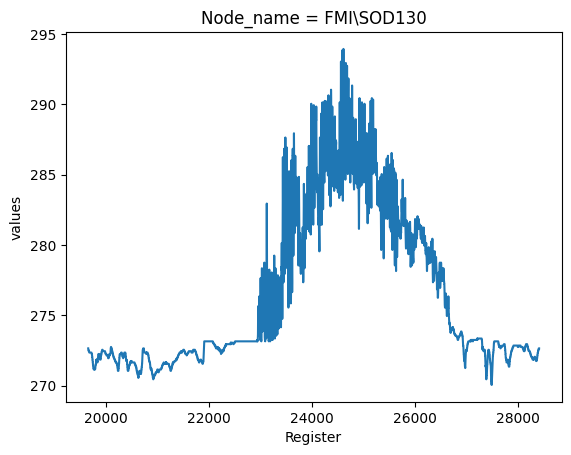

In [13]:
# Values will be extracted the same way
ts_values = ismn_dataset["values"][200,:][ismn_dataset["2017_mask"][200,:] == True]
ts_values.plot()

In [14]:
ts_values

<xarray.DataArray 'values' (Register: 8758)>
[8758 values with dtype=float64]
Coordinates:
  * Register   (Register) int32 19657 19658 19659 19660 ... 28412 28413 28414
    Node_name  <U10 'FMI\\SOD130'

In [149]:
print(ts_values_trimmed.shape) # Tiene las dimensiones apropiadas
ts_matrix = np.zeros(shape= (1369,8758))
ts_matrix[200,:] = ts_values_trimmed

(8758,)


1483228800.0 1483228800


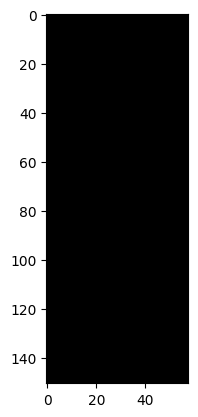

In [114]:
print(actual_recorded_time[0], valid_times[0])
plt.imshow((actual_recorded_time == valid_times).reshape(151,58), cmap='gray', interpolation='nearest')
plt.show()

We kind of get away with ignoring daylight saving time, since sattelites don't stop 1h either. The images shows black but onyl because all values are the same and the default is black.

In [117]:
(actual_recorded_time == valid_times).sum(), len(actual_recorded_time)

(8758, 8758)

In [ ]:
# Lets create the new array row by row, recording the value of the array only where the 2017_mask is True, 
# if the register is incomplete we sould set a fill value.

# This is not efficient
# ts_matrix = np.zeros(shape=(1369,8758))

# for i,node in enumerate(ismn_dataset["Node_name"]):
#     ts_values = ismn_dataset.where(ismn_dataset["2017_mask"] == True)['values'][i,:]
#     ts_values_trimmed = ts_values[ismn_dataset["2017_mask"][i,:] == True]
#     if len(ts_values_trimmed) == 8758 :
#         ts_matrix[i,:] = ts_values_trimmed
#     else:
#         ts_matrix[i,:] = 0


In [38]:
node_names = ds["Node_name"].values


'ARM\\Anthony'

In [49]:
# Define the epty dataset
ds = xr.Dataset(coords={"Node_name": ismn_dataset["Node_name"],
                        'time' : valid_times}, data_vars = {"ts_value":(["Node_name","time"], np.zeros(shape=(1369,8758)))}
)

for i,node in enumerate(ds["Node_name"]):
    ts_values = ismn_dataset["values"][i,:][ismn_dataset["2017_mask"][i,:] == True]
    if len(ts_values.values) == 8758: # only a few nodes have the full 2017 year data
        ds["ts_value"][i,:] = ts_values.values

# TODO: Asign the missing values somehow
    # Fill the missing values with 0 then add the node row OR
    # Assing each value-time pari into the array individually

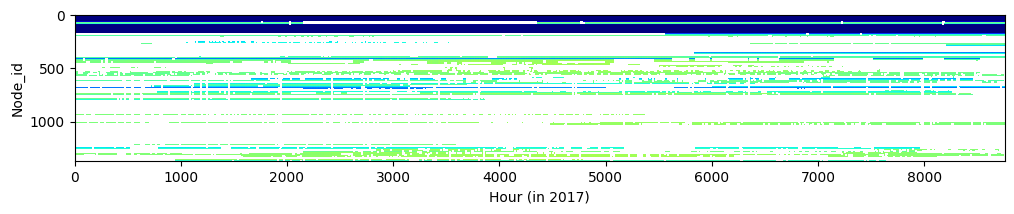

In [59]:
plt.figure(figsize =(12,12))
plt.imshow(ds["ts_value"], cmap = "jet")
plt.xlabel("Hour (in 2017)")
plt.ylabel("Node_id")
plt.show()

In [119]:
# Define and save the dataset
ds = xr.Dataset(coords={"Node_name": ismn_dataset["Node_name"],
                        'time' : valid_times})


<xarray.Dataset>
Dimensions:    (Node_name: 1369, time: 8758)
Coordinates:
  * Node_name  (Node_name) object 'ARM\\Anthony' ... 'WSMN\\WSMN-2'
  * time       (time) int64 1483228800 1483232400 ... 1514750400 1514754000
Data variables:
    *empty*